# Create model arquitecture

In [11]:
from tensorflow.keras import layers
from tensorflow import keras, dtypes
from tensorflow.data import Dataset
from tensorflow import feature_column
import tensorflow as tf

from preprocess_tf import preprocessing_fn

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import random
import os

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value

os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value

random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

In [13]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, target_name, shuffle=True, batch_size=100):
    dataframe = dataframe.copy()
    targets = dataframe.pop(target_name)
    ds = Dataset.from_tensor_slices((dict(dataframe), targets))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [14]:
def set_numerical_feature(name):
    
    numerical_feature = feature_column.numeric_column(name, dtype=dtypes.float64)
    
    return numerical_feature
    
def set_one_hot_feature(name, data):
    one_hot_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    one_hot_feature = feature_column.indicator_column(one_hot_feature)
    
    return one_hot_feature

def set_embedding_feature(name, data, dims):
    embedding_feature = feature_column.categorical_column_with_vocabulary_list(name, data[name].unique().tolist())
    embedding_feature = feature_column.embedding_column(embedding_feature, dimension=dims)
    
    return embedding_feature

In [15]:
def feature_columns(data, dataset):
    
    feature_columns = []

    # numeric cols
    for header in ['yearOfRegistration', 'powerPS', 'kilometer']:
        feature_columns.append(set_numerical_feature(header))

    feature_columns.append(set_one_hot_feature('abtest', data))
    
    feature_columns.append(set_embedding_feature('vehicleType', data, 5))
    
    feature_columns.append(set_one_hot_feature('gearbox', data))
    
    feature_columns.append(set_one_hot_feature('fuelType', data))
    
    feature_columns.append(set_one_hot_feature('notRepairedDamage', data))
    
    feature_columns.append(set_one_hot_feature('cluster_pcode', data))
    
    feature_columns.append(set_one_hot_feature('cluster_model', data))
    
    feature_columns.append(set_one_hot_feature('cluster_brand', data))
    

    feature_layer = layers.DenseFeatures(feature_columns)
    
    return(feature_layer)

In [16]:
train = preprocessing_fn(
    path='data/train.csv',
    na_encoding='data/gearbox_powerps_na.csv',
    norm_params='data/numerical_features_normalization.csv',
    brand_clusters='data/brand_clusters.csv',
    model_clusters='data/model_clusters.csv',
    postalcode_clusters='data/postalcode_clusters.csv'
)
val = preprocessing_fn(
    path='data/val.csv',
    na_encoding='data/gearbox_powerps_na.csv',
    norm_params='data/numerical_features_normalization.csv',
    brand_clusters='data/brand_clusters.csv',
    model_clusters='data/model_clusters.csv',
    postalcode_clusters='data/postalcode_clusters.csv'
)

print(train.shape)
print(val.shape)

(180460, 12)
(45201, 12)


In [17]:
train.dtypes

price                   int64
abtest                 object
vehicleType            object
yearOfRegistration    float32
gearbox                object
powerPS               float32
kilometer             float32
fuelType               object
notRepairedDamage      object
cluster_brand           int32
cluster_model           int32
cluster_pcode           int32
dtype: object

In [18]:
train_ds = df_to_dataset(dataframe=train, target_name='price', shuffle=True, batch_size=512)
val_ds = df_to_dataset(dataframe=val, target_name='price', shuffle=True, batch_size=512)

In [19]:
feature_layer = feature_columns(train, train_ds)

Epoch 1/60
353/353 [==============================] - 8s 23ms/step - loss: 33606912.0000 - mean_absolute_error: 3745.3271 - mean_squared_error: 33606912.0000 - val_loss: 8139911.5000 - val_mean_absolute_error: 1806.1296 - val_mean_squared_error: 8139911.5000
Epoch 2/60
353/353 [==============================] - 8s 22ms/step - loss: 6750262.5000 - mean_absolute_error: 1695.5253 - mean_squared_error: 6750262.5000 - val_loss: 6090669.5000 - val_mean_absolute_error: 1574.5825 - val_mean_squared_error: 6090669.5000
Epoch 3/60
353/353 [==============================] - 8s 22ms/step - loss: 5869267.5000 - mean_absolute_error: 1482.4486 - mean_squared_error: 5869267.5000 - val_loss: 5325018.0000 - val_mean_absolute_error: 1384.2041 - val_mean_squared_error: 5325018.0000
Epoch 4/60
353/353 [==============================] - 8s 22ms/step - loss: 5486611.0000 - mean_absolute_error: 1412.0146 - mean_squared_error: 5486611.0000 - val_loss: 6544918.0000 - val_mean_absolute_error: 1483.5428 - val_mea

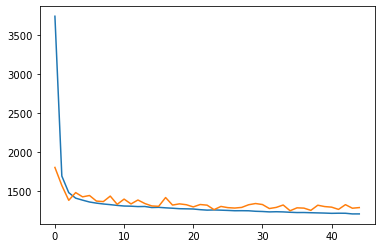

In [69]:
dp_rate = 0.1
lr = 0.001
hu = 300
momentum = 0.9

model = keras.Sequential([
    feature_layer,
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.BatchNormalization(momentum=momentum),
    layers.Dropout(rate=dp_rate),
    layers.Dense(hu),
    layers.Activation('relu'),
    layers.Dense(1, activation='relu')
])

# Compile Keras model
model.compile(
    loss='mean_squared_error',
    metrics=['mean_absolute_error','mean_squared_error'],
    optimizer=keras.optimizers.Adam(learning_rate=lr))

# fit model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

# get results
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plt.plot(hist.epoch, hist.mean_absolute_error)
plt.plot(hist.epoch, hist.val_mean_absolute_error)
plt.show()

In [70]:
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,33606912.00,3745.327148,33606912.00,8139911.5,1806.129639,8139911.5,0
1,6750262.50,1695.525269,6750262.50,6090669.5,1574.582520,6090669.5,1
2,5869267.50,1482.448608,5869267.50,5325018.0,1384.204102,5325018.0,2
3,5486611.00,1412.014648,5486611.00,6544918.0,1483.542847,6544918.0,3
4,5304072.50,1386.369141,5304072.50,5809849.0,1428.764282,5809849.0,4
5,5150628.00,1362.685425,5150628.00,6174055.0,1446.039185,6174055.0,5
6,5028011.50,1348.324585,5028011.50,5471837.5,1374.520508,5471837.5,6
7,4934333.00,1337.268433,4934333.00,5239642.0,1368.035400,5239642.0,7
8,4860760.00,1328.791382,4860760.00,5895786.0,1438.463989,5895786.0,8
9,4795546.50,1319.097656,4795546.50,5199350.5,1332.830811,5199350.5,9


In [71]:
val_pred = model.predict(df_to_dataset(dataframe=val, target_name='price', shuffle=False, batch_size=1000)).flatten() 

In [72]:
val['price_pred'] = val_pred
val['abs_error'] = abs(val.price_pred - val.price)
val['error'] = val.price_pred - val.price

worst_predictions = val.copy().loc[val.abs_error >= val.abs_error.quantile(0.9)]

In [73]:
# super baseline model
np.mean(np.abs(val.price - train.price.mean()))

4566.433744420169

In [74]:
# my model
np.mean(np.abs(val.price - val_pred))

1291.0638130140558

In [75]:
# r squared
ss_res = np.sum((val.price - val.price_pred)**2)
ss_tot = np.sum((val.price - np.mean(val.price))**2)
r2 = 1 - ss_res/ss_tot
r2

0.8753913367409185

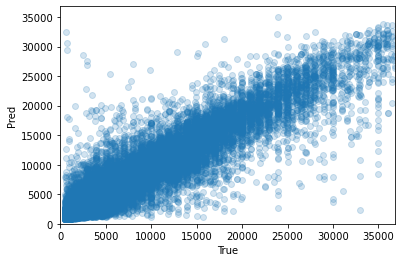

In [76]:
plt.scatter(val.price, val_pred, alpha=0.2)
plt.xlim([0, val.price.max()])
plt.ylim([0, val.price.max()])
plt.xlabel('True')
plt.ylabel('Pred')
plt.show()

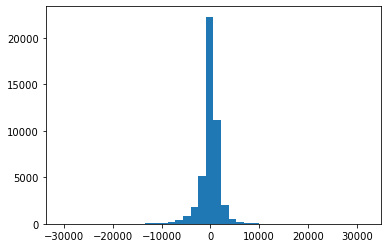

In [77]:
plt.hist(val.error, bins=40)
plt.show()

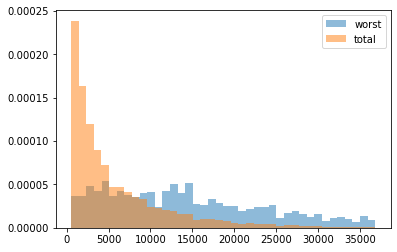

In [78]:
plt.hist(worst_predictions.price, bins=40, alpha=0.5, density=True, label='worst')
plt.hist(val.price, bins=40, alpha=0.5, density=True, label='total')
plt.legend()
plt.show()

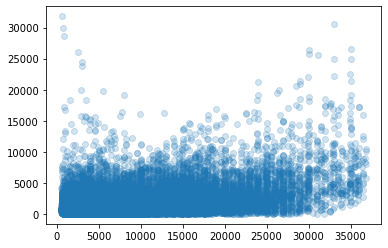

In [79]:
plt.scatter(val.price, val.abs_error, alpha=0.2)
plt.show()

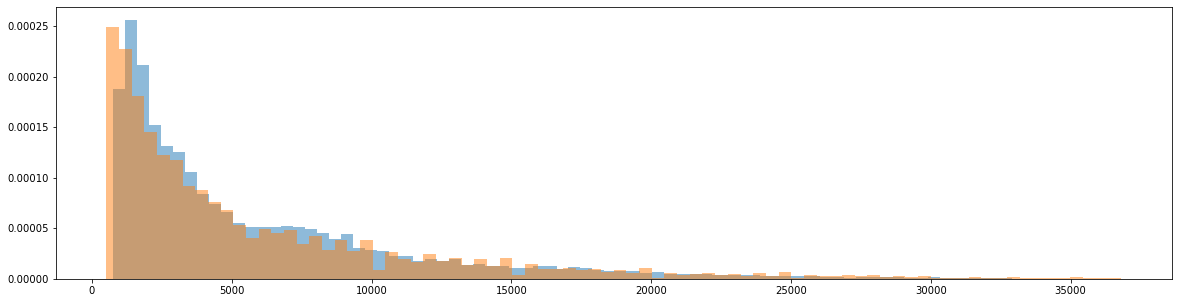

In [80]:
plt.figure(figsize=(20,5))
plt.hist(val.price_pred, bins=80, alpha=0.5, density=True)
plt.hist(val.price, bins=80, alpha=0.5, density=True)
plt.show()

In [81]:
i = 5000
print(val.price[i])
print(val.price_pred[i])

4950
3253.9539


In [82]:
val_low = val.copy().loc[val.price < 1000,]
val_pred_low = val_pred.copy()[val.price < 1000]

np.mean(np.abs(val_low.price - val_pred_low))

707.0175207924603